In [1]:
import sys
import os

sys.path.append(os.path.abspath("../..")) #make the folder "automl" part of this


### Define Hyperparameters

In [2]:
num_episodes = 5
state_memory_size = 1
limit_steps = 100
optimization_interval = 50

### RL Trainer Component

In [3]:
%load_ext autoreload
%autoreload 2

from automl.rl.rl_pipeline import RLPipelineComponent


rl_pipeline_input = {
    "device" : "gpu",
    "num_episodes" : num_episodes,
    "state_memory_size" : 2,
    "limit_steps" : limit_steps ,
    "optimization_interval" : optimization_interval
}


rl_pipeline = RLPipelineComponent(input=rl_pipeline_input)

### Do the training

In [4]:
rl_pipeline.train()

TypeError: On Component RLPipelineComponent of type RLPipelineComponent:
 openLog() got an unexpected keyword argument 'dir'

### See results

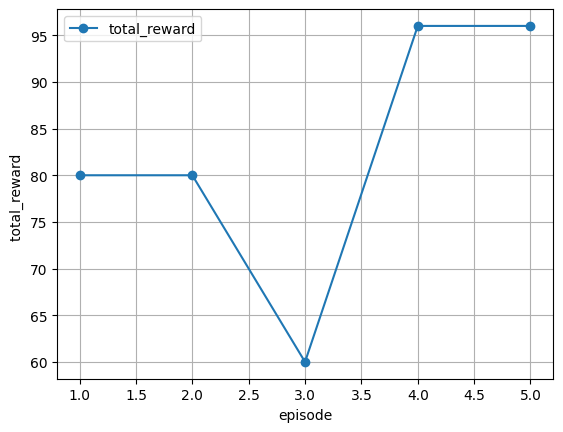

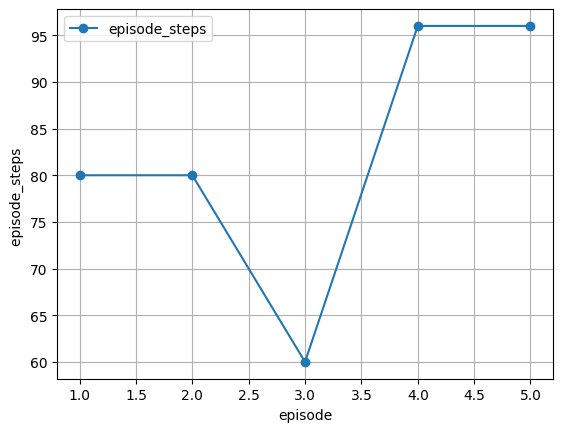

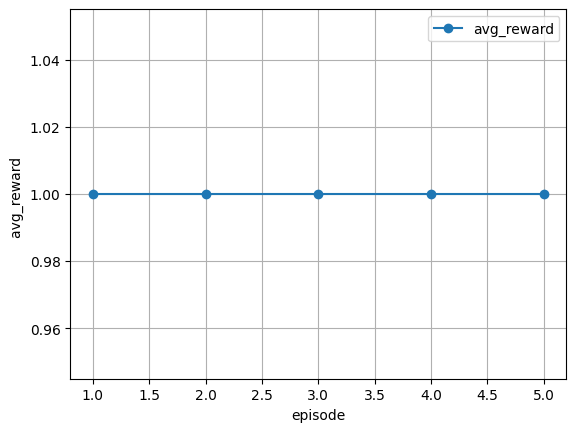

In [5]:
rl_pipeline.plot_graphs()

### Save configuration

In [6]:
rl_pipeline.save_configuration(toPrint=True)

{
    "__type__": "<class 'automl.rl.rl_pipeline.RLPipelineComponent'>",
    "name": "RLPipelineComponent",
    "input": {
        "num_episodes": 5,
        "state_memory_size": 2,
        "limit_steps": 100,
        "optimization_interval": 50,
        "environment": {
            "__type__": "PettingZooEnvironmentLoader",
            "name": "PettingZooEnvironmentLoader",
            "localization": [
                0
            ]
        },
        "agents": {
            "paddle_0": {
                "__type__": "AgentTrainer",
                "name": "AgentTrainer",
                "localization": [
                    3,
                    0
                ]
            },
            "paddle_1": {
                "__type__": "AgentTrainer",
                "name": "AgentTrainer",
                "localization": [
                    3,
                    1
                ]
            }
        },
        "save_interval": 100,
        "rl_trainer": "",
        "created_ag